<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/deep-learning-fundamentals/unit05-lightning/01_mlp_with_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multilayer Perceptron in PyTorch & Lightning

**Reference**

https://lightning.ai/pages/courses/deep-learning-fundamentals/overview-organizing-your-code-with-pytorch-lightning/5-2-training-a-multilayer-perceptron-using-the-lightning-trainer/

## 1) Setup

In [ ]:
!wget https://github.com/Lightning-AI/dl-fundamentals/raw/main/unit05-lightning/5.2-mlp-lightning/shared_utilities.py

In [ ]:
!pip install torch torchvision torchaudio
!pip install lightning

In [3]:
!lightning --version

lightning, version 2.0.0


In [1]:
import torch
import torchvision
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import lightning as L

import numpy as np
from collections import Counter

%matplotlib inline
import matplotlib.pyplot as plt

from shared_utilities import PyTorchMLP, compute_accuracy, get_dataset_loaders

## 2) Loading the dataset

- MNIST website: http://yann.lecun.com/exdb/mnist/

In [ ]:
train_dataset = datasets.MNIST(
    root="./mnist", train=True, transform=transforms.ToTensor(), download=True
)

test_dataset = datasets.MNIST(
    root="./mnist", train=False, transform=transforms.ToTensor()
)

In [3]:
len(train_dataset)

60000

In [4]:
len(test_dataset)

10000

### Create a validation set

In [5]:
torch.manual_seed(1)

train_dataset, val_dataset = random_split(train_dataset, lengths=[55000, 5000])

In [6]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=64,
    shuffle=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

###Check label distribution

In [7]:
train_counter = Counter()
for images, labels in train_loader:
    train_counter.update(labels.tolist())
    
print("\nTraining label distribution:")
print(sorted(train_counter.items()))

    
val_counter = Counter()
for images, labels in val_loader:
    val_counter.update(labels.tolist())
    
print("\nValidation label distribution:")
print(sorted(val_counter.items()))
    

test_counter = Counter()
for images, labels in test_loader:
    test_counter.update(labels.tolist())

print("\nTest label distribution:")
print(sorted(test_counter.items()))


Training label distribution:
[(0, 5419), (1, 6185), (2, 5477), (3, 5681), (4, 5349), (5, 4974), (6, 5422), (7, 5710), (8, 5351), (9, 5432)]

Validation label distribution:
[(0, 504), (1, 557), (2, 481), (3, 450), (4, 493), (5, 447), (6, 496), (7, 555), (8, 500), (9, 517)]

Test label distribution:
[(0, 980), (1, 1135), (2, 1032), (3, 1010), (4, 982), (5, 892), (6, 958), (7, 1028), (8, 974), (9, 1009)]


###Zero-rule baseline

In [8]:
majority_class = test_counter.most_common(1)[0]
print(f"Majority class: {majority_class[0]}")

baseline_acc = majority_class[1] / sum(test_counter.values())
print(f"Accuracy when always predicting the majority class: {baseline_acc:.2f} ({baseline_acc * 100}%)")

Majority class: 1
Accuracy when always predicting the majority class: 0.11 (11.35%)


###A quick visual check

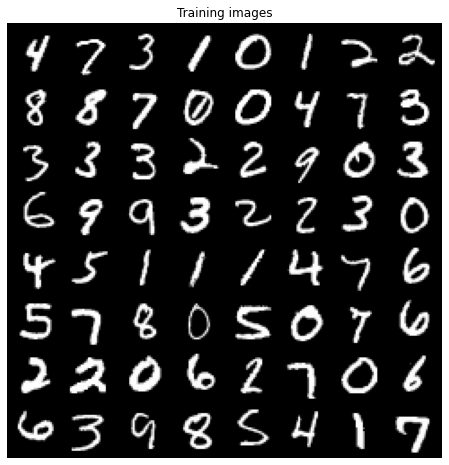

In [9]:
for images, labels in train_loader:  
  break

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training images")
plt.imshow(np.transpose(torchvision.utils.make_grid(
    images[:64], 
    padding=2,
    normalize=True),
    (1, 2, 0)))
plt.show()

## 3) Implementing the model

In [10]:
class LightningModel(L.LightningModule):
    def __init__(self, model, learning_rate):
      super().__init__()

      self.learning_rate = learning_rate
      self.model = model

    def forward(self, x):
      return self.model(x)

    def training_step(self, batch, batch_idx):
      features, true_labels = batch
      logits = self(features)
      loss = F.cross_entropy(logits, true_labels)
      self.log("train_loss", loss)
      # this is passed to the optimizer for training
      return loss

    def validation_step(self, batch, batch_idx):
      features, true_labels = batch
      logits = self(features)
      loss = F.cross_entropy(logits, true_labels)
      self.log("val_loss", loss, prog_bar=True)

    def configure_optimizers(self):
      optimizer = torch.optim.SGD(self.parameters(), lr=self.learning_rate)
      return optimizer

## 4) The training model

In [ ]:
print("Torch CUDA available?", torch.cuda.is_available())

train_loader, val_loader, test_loader = get_dataset_loaders()

pytorch_model = PyTorchMLP(num_features=784, num_classes=10)
lightning_model = LightningModel(model=pytorch_model, learning_rate=0.5)

trainer = L.Trainer(
  max_epochs=10,
  accelerator="auto", # set to "auto" or "gpu" to use GPUs if available
  devices="auto"      # Uses all available GPUs if applicable
)

trainer.fit(
  model=lightning_model,
  train_dataloaders=train_loader,
  val_dataloaders=val_loader
)

train_acc = compute_accuracy(pytorch_model, train_loader)
val_acc = compute_accuracy(pytorch_model, val_loader)
test_acc = compute_accuracy(pytorch_model, test_loader)

In [12]:
print(f"Train Acc {train_acc*100:.2f}% | Val Acc {val_acc*100:.2f}% | Test Acc {test_acc*100:.2f}%")

Train Acc 97.49% | Val Acc 96.30% | Test Acc 96.20%


In [13]:
# save the model
PATH = "lightning.pt"
torch.save(pytorch_model.state_dict(), PATH)

In [14]:
# load the model
model = PyTorchMLP(num_features=784, num_classes=10)
model.load_state_dict(torch.load(PATH))
model.eval()

PyTorchMLP(
  (all_layers): Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=10, bias=True)
  )
)